In [1]:
data_dir = "C:/Users/elev/Documents/machine learning/CNN Flowers"
train_path = data_dir + "/flowers"

In [2]:
import cv2, os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ResNet34; input 224x224
# ResNet20; input 32x32
img_size = 32

data = []
labels = []

classes = {}

for dirnum, dirname in enumerate(os.listdir(train_path)):
    for filename in os.listdir(os.path.join(train_path, dirname)):
        file_path = os.path.join(train_path, dirname, filename)
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        

        data.append(transform(img_rgb))
        labels.append(dirnum)
    
    classes[dirnum] = dirname

def translate_label(y, translation=classes):
    return pd.series(y).apply(lambda y: translation[int(y)]).values

In [3]:
from sklearn.model_selection import train_test_split
import torch

x_train, x_test, y_train, y_test = train_test_split(
    torch.stack(data),
    torch.Tensor(labels).long(),
    test_size=0.1,
    random_state=10
)

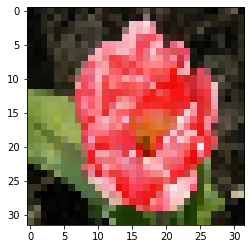

In [49]:
import numpy as np
from random import randint

def show_image(image):
    tensor = image.unsqueeze_(0)
    image = np.squeeze(tensor.numpy())
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = image.transpose((1, 2, 0))
    plt.imshow(image)

index = randint(0, len(x_test)-1)
show_image(x_train[index])

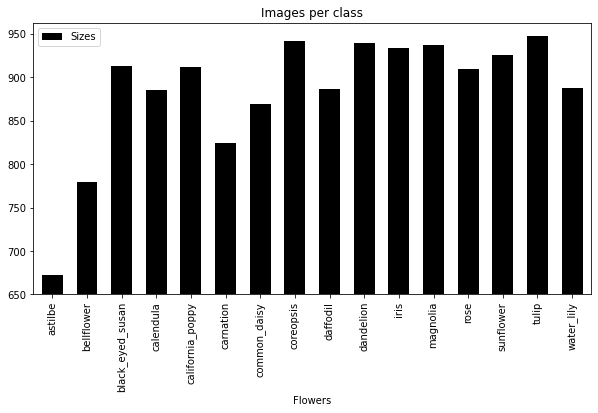

In [114]:
values = []
bottom = 650

import pandas as pd
for i in range(len(classes)):
    values.append([int((y_train == i).float().sum()) - bottom, classes[i]])

df = pd.DataFrame(
    values,
    columns=['Sizes', 'Flowers']
).set_index('Flowers').plot(
    title="Images per class",
    kind="bar",
    color="k",
    bottom=bottom,
    width=0.6,
    figsize=(10, 5)
)

In [6]:
import torch.nn as nn

def conv3x3(inplanes, planes, stride=1):
    return nn.Conv2d(
        in_channels=inplanes,
        out_channels=planes,
        kernel_size=(3, 3),
        stride=stride,
        padding=1,
        bias=False,
    )

def conv1x1(inplanes, planes, stride=1):
    return nn.Conv2d(
        in_channels=inplanes,
        out_channels=planes,
        kernel_size=(1, 1),
        stride=stride,
        padding=0,
        bias=False,
    )

class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        return self.relu(out)

In [7]:
import torch.nn as nn

class ResNet20(nn.Module):
    def __init__(self, num_classes):
        super(ResNet20, self).__init__()
        
        self.convolution_1 = nn.Sequential(
            conv3x3(3, 16),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        self.convolutional_layer_1 = self.make_layer(16, 16, 3, 1)
        self.convolutional_layer_2 = self.make_layer(16, 32, 3, 2)
        self.convolutional_layer_3 = self.make_layer(32, 64, 3, 2)    
        
        self.avgPool2d = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.linear = nn.Linear(4*4*64, num_classes)
        
    def forward(self, x):
        # Start Convolutional Layers
        x = self.convolution_1(x)
        x = self.convolutional_layer_1(x)
        x = self.convolutional_layer_2(x)
        x = self.convolutional_layer_3(x)
        x = self.avgPool2d(x)
        
        # Flatten input
        x = torch.flatten(x, 1)
        
        # Start Neural Network
        x = self.linear(x)
        return x
    
    def make_layer(self, inplanes, planes, blocks, stride=1):
        layer = []
        downsample = None
        
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride=stride),
                nn.BatchNorm2d(planes),
            )
        
        # Add first block
        layer.append(BasicBlock(inplanes, planes, stride, downsample))
        
        # Add the rest of the blocks
        for _ in range(1, blocks):
            layer.append(BasicBlock(planes, planes))
            
        return nn.Sequential(*layer)

model = ResNet20(len(classes))

In [8]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias != None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [9]:
model.apply(initialize_weights)
criterion = nn.CrossEntropyLoss()

#model.load_state_dict(torch.load("ResNet20.pt"))

In [32]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.9, weight_decay=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [11]:
import json
def load_file(load=True):
    try:
        if load:
            with open('model_score.json', 'r') as f:
                return json.load(f)
    except:
        pass
    
    return {
        'Batch-Size': batch_size,
        'Epochs': 0,
        'Train-Accuracy': [],
        'Test-Accuracy': [],
        'Loss': [],
    }

def save_file(score):
    json_object = json.dumps(score, indent = 4)
    with open("model_score.json", "w") as file:
        file.write(json_object)

In [13]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

trainset = TensorDataset(x_train, y_train)
testset = TensorDataset(x_test, y_test)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, shuffle=True)

In [14]:
score = load_file(False)
score['Batch-Size'] = batch_size

In [33]:
model.train()
iterations = 5

for epoch in range(iterations):
    
    correct = 0.0
    running_loss = 0.0
    
    try:
        for i, (x_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            y_batch_pred = model(x_batch)
            loss = criterion(y_batch_pred, y_batch)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = y_batch_pred.max(dim = 1)[1]
            correct += (preds == y_batch).float().sum()

        epoch_loss = float(running_loss / i)
        train_acc = float(100 * correct / len(trainset))
        
        with torch.no_grad():
            y_test_pred = model(x_test)
            preds = y_test_pred.max(dim = 1)[1]
            test_acc = float(100 * (preds == y_test).float().sum() / len(y_test))
        
        score['Train-Accuracy'].append(train_acc)
        score['Test-Accuracy'].append(test_acc)
        score['Loss'].append(epoch_loss)
        score['Epochs'] += 1

        print('Epoch [%d/%d] Loss: %.4f Train-Accuracy: %.3f Test-Accuracy: %.3f' % (epoch+1, iterations, epoch_loss, train_acc, test_acc))
    except KeyboardInterrupt:
        break

Epoch [1/5] Loss: 0.3275 Train-Accuracy: 88.889 Test-Accuracy: 64.676
Epoch [2/5] Loss: 0.2742 Train-Accuracy: 90.308 Test-Accuracy: 64.867
Epoch [3/5] Loss: 0.2701 Train-Accuracy: 90.505 Test-Accuracy: 62.961
Epoch [4/5] Loss: 0.2713 Train-Accuracy: 90.604 Test-Accuracy: 62.706
Epoch [5/5] Loss: 0.2255 Train-Accuracy: 92.263 Test-Accuracy: 61.563


In [43]:
save_file(score)

In [44]:
# Calculate class accuracies
with torch.no_grad():
    output = model(x_test)
    preds = output.max(dim = 1)[1]

    test_acc = (preds == y_test)
    for key, value in classes.items():
        c = (test_acc * (y_test == key)).float().sum()
        class_acc = float(100 * c / (y_test == key).float().sum())
        print('%s: %.3f' % (value, class_acc))
    
    print("Total Accuracy score: {0:.3f}%".format(test_acc.float().sum()/len(test_acc)*100))

astilbe: 46.154
bellflower: 64.516
black_eyed_susan: 62.069
calendula: 34.409
california_poppy: 53.636
carnation: 30.303
common_daisy: 71.171
coreopsis: 73.333
daffodil: 83.133
dandelion: 69.912
iris: 69.167
magnolia: 57.658
rose: 48.315
sunflower: 79.208
tulip: 89.000
water_lily: 48.936
Total Accuracy score: 61.881%


Image of a astilbe predicted to 62.501% of class astilbe
Image of a water_lily predicted to 99.935% of class water_lily
Image of a bellflower predicted to 82.61% of class magnolia


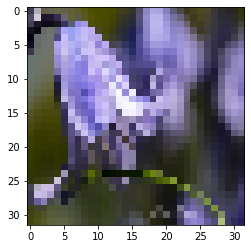

In [45]:
from random import randint

def predict_image(tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(tensor)
        prob = outputs.softmax(1)
        return prob.topk(1, dim = 1, largest=True)

def predict_random_image(amount=1):
    for i in range(amount):
        
        index = randint(0, len(x_test))
        tensor = x_test[index].unsqueeze_(0)
        y = y_test[index]

        top_p, top_class = predict_image(tensor)
        
        print("Image of a {} predicted to {}% of class {}".format(
            classes[y.item()],
            str(round(top_p.item()*100, 3)),
            classes[top_class.item()]
        ))
        show_image(tensor)
        
predict_random_image(3)

In [38]:
torch.save(model.state_dict(), "ResNet20_Flower.pt")

Text(0, 0.5, 'Loss')

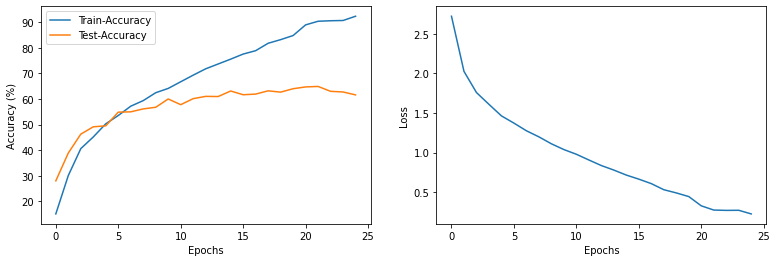

In [86]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

x = [i for i in range(score["Epochs"])]
axs[0].plot(x, score["Train-Accuracy"], label="Train-Accuracy")
axs[0].plot(x, score["Test-Accuracy"], label="Test-Accuracy")
#axs[0].title("Accuracy after 25 epochs")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(x, score["Loss"])
#axs[1].title("Loss after 25 epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")